In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from netCDF4 import Dataset
import glob, sys

#from FiniteDiff import FiniteDiff
from matpy import FiniteDiff

## For each of our dataset files, load in the large-scale KE

In [2]:
full_data = dict( filename = 'RESULTS_full.nc',      label = 'Full Vel.' )
tor_data  = dict( filename = 'RESULTS_toroidal.nc',  label = 'Tor. Vel.' )
pot_data  = dict( filename = 'RESULTS_potential.nc', label = 'Pot. Vel.' )

for dataset in [ full_data, tor_data, pot_data]:
    with Dataset(dataset['filename'], 'r') as dset:

        ## Load in the dimensions and grid
        dataset['ell'] = dset['ell'][:]
        dataset['regions'] = [ reg.strip() for reg in dset['region'] ]
        dataset['depth'] = dset['depth'][:]
        dataset['time'] = dset['time'][:]

        # Load in the large-scale KE
        dataset['cKE'] = dset['coarse_KE_area_average'][:,:,:,:]

        # If there had been land, we would want to normalize
        # our averages by water area, not total area.
        # Not necessary for this case, but included for completeness
        dataset['region_area_total'] = dset['region_areas'][:]
        dataset['region_area_water'] = dset['region_areas_water_only'][:]
        area_correction = dataset['region_area_total'] / dataset['region_area_water']
        dataset['cKE'] = area_correction * dataset['cKE']


        # Now do a k-derivative to get the spectrum
        dataset['ddk'] = FiniteDiff( 1. / dataset['ell'], 4, Uniform = False, Periodic = False, Sparse = True )
        dataset['ddlogk'] = FiniteDiff( np.log10(1. / dataset['ell']), 4, Uniform = False, Periodic = False, Sparse = True )

        dataset['ddk_cKE'] = np.zeros( dataset['cKE'].shape )
        dataset['ddlogk_cKE'] = np.zeros( dataset['cKE'].shape )
        for JJ in range( dataset['cKE'].shape[-1] ):
            for II in range( dataset['cKE'].shape[-2] ):
                dataset['ddk_cKE'][:,:,II,JJ] = dataset['ddk'].dot( dataset['cKE'][:,:,II,JJ] )
                dataset['ddlogk_cKE'][:,:,II,JJ] = dataset['ddlogk'].dot( dataset['cKE'][:,:,II,JJ] )

## Now create a plot of the power spetrum, showing the Helmholtz decomposition

Notice that we've included vertical lines for the scales where we preferrentially generated data.

We have the typical small-scale 'divot' near 200km because of the coarse resolution of our dataset, indicating that results smaller than those scales should not be considered resolved.

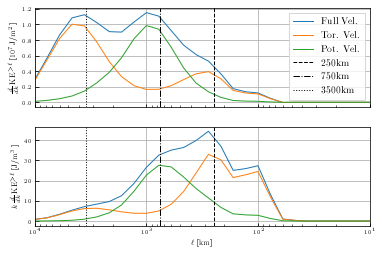

In [3]:
fig, axes = plt.subplots( 2, 1, sharex = True )

for Iset, dataset in enumerate([ full_data, tor_data, pot_data]):
    Iregion = dataset['regions'].index('Global')

    axes[0].plot( dataset['ell'] / 1e3, dataset['ddk_cKE'   ][:,0,0,Iregion] / 1e7, label = dataset['label'] )
    axes[1].plot( dataset['ell'] / 1e3, dataset['ddlogk_cKE'][:,0,0,Iregion],       label = dataset['label'] )

for ax in axes:
    ax.set_xscale('log')
axes[-1].set_xlabel('$\ell$ [km]')

styles = ['--', '-.', ':']
for ax in axes:
    ax.set_ylim( ax.get_ylim() )
    for Iscale, scale in enumerate([250, 750, 3500]):
        ax.plot( [scale, scale], ax.get_ylim(), label = "{0:d}km".format(int(scale)), linestyle = styles[Iscale], color = 'k' )
    ax.grid()
    ax.set_xlim( 1e4, 1e1 )


axes[0].set_ylabel('$\\frac{d}{dk}\\mathrm{KE}^{>\ell}$ [$10^7$J/m$^2$]')
axes[1].set_ylabel('$k\\frac{d}{dk}\\mathrm{KE}^{>\ell}$ [J/m$^3$]')

axes[0].legend()

plt.savefig('Filtering_Spectra.pdf')